# Train a CNN on the color-based training set.
Classify patches from all Y-neg tumors.  
Regain those that are certainly blue or certainly green.
Stuck: out of memory trying to load X_train.  
Stuck: loss=nan during first epoch using only one image.

In [1]:
import time
import os
import glob
import cv2 # OpenCV-Python
from PIL import Image
Image.MAX_IMAGE_PIXELS = None
import numpy as np
import json
DIR_IMAGES_RAW = "/home/jrm/Martinez/images/raw/"
DIR_IMAGES_OUT = "/home/jrm/Martinez/images/temp/"
PATTERN_IMAGES_RAW = "*.DF1.*.tif"
PATCH_SIZE=224  # matches VGG
IMAGE_FILENAME='B13.DF1.115.tif'

In [2]:
DF_Ypos = ['B7.','B15','D1.','D5.','E7.','E9.','F9.','G3.','H13','I1.','I5.','I13']
DF_Yneg = ['A3.','A5.','B13','C1.','C11','D3.','E5.','F3.','F7','F11','F13','F15','G15','H1.','H3.','H7.','H15']

In [3]:
def get_image_names(path,pattern):
    #RAW_IMAGE_NAMES = os.listdir(DIR_IMAGES_RAW)
    paths = glob.glob(path+pattern)
    names = [os.path.basename(x) for x in paths]
    return names
FILENAMES_IMAGES_RAW = get_image_names(DIR_IMAGES_RAW,PATTERN_IMAGES_RAW)
#FILENAMES_IMAGES_RAW

In [4]:
class patch_maker:
    def __init__(self):
        self.path=""
        self.w=0
        self.h=0
        self.im_width = 0
        self.im_height = 0
        self.patch_size = 10 # scalar, assumed square for now
        self.pixel_array = None
    def set_input_path(self,path):
        self.path=path
    def set_patch_size(self,scalar):
        self.patch_size = scalar
    def load_pixel_array(self,filename,verbose=False):
        self.w=0
        self.h=0
        im = Image.open(self.path+filename)
        ima = np.array(im)   # convert to numpy
        self.im_width = ima.shape[0]
        self.im_height = ima.shape[1]    
        if verbose:
            print(filename, ima.size, ima.shape)
        self.pixel_array = ima
        return ima
    def get_next_patch(self): 
        IM_WIDTH = self.im_width
        IM_HEIGHT = self.im_height
        PIXEL_ARRAY = self.pixel_array
        patch = None
        if self.w+self.patch_size > IM_WIDTH:
            self.h += self.patch_size
            self.w = 0
        if self.w+self.patch_size <= IM_WIDTH and self.h+self.patch_size <= IM_HEIGHT:
            patch = PIXEL_ARRAY[self.w:self.w+self.patch_size, self.h:self.h+self.patch_size]
            self.w += self.patch_size
        return patch

### Image patch counts: green, blue, total
Analyzing F15.DF1.135.tif 34 262 3135   
Analyzing H3.DF1.27.tif 110 30 3135  
Analyzing C11.DF1.96.tif 292 16 3135  
Analyzing C1.DF1.01.tif 69 293 3135  
Analyzing F11.DF1.94.tif 54 375 3135  
Analyzing H7.DF1.62.tif 178 228 3135  
Analyzing A3.DF1.26.tif 1 1482 3135  
Analyzing A5.DF1.45.tif 454 6 3135  
Analyzing H15.DF1.132.tif 66 0 3135  
Analyzing G15.DF1.133.tif 239 0 3135  
Analyzing F3.DF1.22.tif 430 41 3135  
Analyzing B13.DF1.115.tif 70 407 3135  
Analyzing D3.DF1.20.tif 325 4 3135  
Analyzing E5.DF1.42.tif 31 266 3135  
Analyzing H1.DF1.07.tif 593 0 3135  

In [5]:
NO_GREEN_INTENSITY=np.array( [0,35,0] )
NO_BLUE_INTENSITY=np.array( [0,0,30] )
pm = patch_maker()
pm.set_input_path(DIR_IMAGES_RAW)
pm.set_patch_size(PATCH_SIZE)
X_train=[]
Y_train=[]
X_valid=[]
Y_valid=[]
VMOD=10
pcount=0
BLUE=1
GREEN=0
def add_patch (patch, color):  # TO DO: make this a class, dispense with globals
    global pcount
    global VMOD
    if pcount >= VMOD:
        X_valid.append(patch)
        Y_valid.append(color)
        pcount = 0
    else:
        X_train.append(patch)
        Y_train.append(color)
        pcount += 1
for filename in FILENAMES_IMAGES_RAW:
    prefix = filename[0:3]
    if prefix in DF_Yneg:
        print(filename,end=", ")
        pixels = pm.load_pixel_array(filename)
        patch = pm.get_next_patch()
        while patch is not None:
            num_green_pixels = np.sum(np.all(patch >= NO_GREEN_INTENSITY,axis=2))
            num_blue_pixels = np.sum(np.all(patch >= NO_BLUE_INTENSITY,axis=2))
            if num_blue_pixels>=10000 and num_blue_pixels>num_green_pixels*20:
                add_patch(patch,BLUE)
            elif num_green_pixels>=15000 and num_green_pixels>num_blue_pixels*2:
                add_patch(patch,GREEN)
            patch = pm.get_next_patch()
    break  # FOR STARTERS, JUST PROCESS ONE FILE!
print()
# Required for tensorflow+
X_train = np.asarray(X_train)
Y_train = np.asarray(Y_train)
X_valid = np.asarray(X_valid)
Y_valid = np.asarray(Y_valid)

F15.DF1.135.tif, 


In [6]:
print(type(X_train))
print(len(X_train))
print(X_train[0].shape)
print(Y_valid)

<class 'numpy.ndarray'>
270
(224, 224, 3)
[1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1]


In [7]:
from tensorflow import keras
import keras.layers as kl
INPUT_SHAPE=[PATCH_SIZE,PATCH_SIZE,3]
cnn = keras.models.Sequential([
    kl.Conv2D(filters=64,kernel_size=7,activation="relu",padding="SAME",
    input_shape=INPUT_SHAPE),
    kl.MaxPooling2D(2),
    kl.Conv2D(128,3,activation="relu",padding="same"),
    kl.Conv2D(128,3,activation="relu",padding="same"),
    kl.MaxPooling2D(2),   
    kl.Conv2D(256,3,activation="relu",padding="same"),
    kl.Conv2D(256,3,activation="relu",padding="same"),
    kl.MaxPooling2D(2), 
    kl.Flatten(),
    kl.Dense(128,activation="relu"),
    kl.Dropout(0.5),
    kl.Dense(64,activation="relu"),
    kl.Dropout(0.5),    
    kl.Dense(2,activation="softmax")
])
# 10 nodes in the output layer
# corresponds to 10 classes of MNIST clothes.
# cnn.layers[0].weights

In [8]:
cnn.compile(loss="sparse_categorical_crossentropy",
           optimizer="sgd",
           metrics=["accuracy"])
hist = cnn.fit(X_train,Y_train,epochs=3,
                 validation_data=(X_valid,Y_valid))

Epoch 1/3
9/9 [==============================] - 35s 4s/step - loss: nan - accuracy: 0.3185 - val_loss: nan - val_accuracy: 0.0769
Epoch 2/3
9/9 [==============================] - 34s 4s/step - loss: nan - accuracy: 0.1185 - val_loss: nan - val_accuracy: 0.0769
Epoch 3/3
9/9 [==============================] - 35s 4s/step - loss: nan - accuracy: 0.1185 - val_loss: nan - val_accuracy: 0.0769


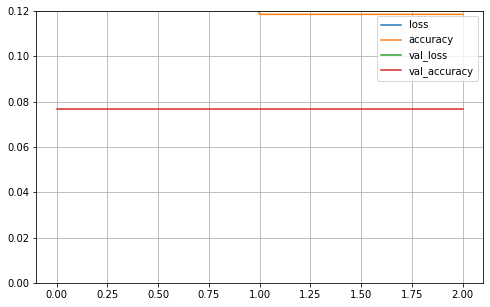

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(hist.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,0.12)
plt.show()